In [38]:
import os
import shutil
import random
import numpy as np
from io import BytesIO
from PIL import Image
import requests
import urllib
from IPython.display import display

from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow import keras
import tensorflow.lite as tflite

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

dataset is taken from https://www.kaggle.com/alxmamaev/flowers-recognition

In [39]:
path = '../data/flowers/'

In [40]:
target_size = (150, 150)

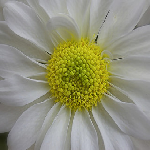

In [41]:
img = load_img(f'{path}daisy/100080576_f52e8ee070_n.jpg', target_size=target_size)
img

# Split data in test, train, validation

In [42]:
flower_types = ['daisy', 'rose', 'tulip', 'dandelion', 'sunflower']

In [43]:
for flower_type in flower_types:
    images = os.listdir(os.path.join(path, flower_type))
    print(f'flower: {flower_type:>10} - number images: {len(images)}')

flower:      daisy - number images: 764
flower:       rose - number images: 784
flower:      tulip - number images: 984
flower:  dandelion - number images: 1052
flower:  sunflower - number images: 733


In [ ]:
for folder in ['train', 'validation', 'test']:
    for flower_type in flower_types:
        directory = os.path.join(path, folder, flower_type)
        if not os.path.exists(directory):
            os.makedirs(directory)
            print(f'created dir {directory}')

In [ ]:
test_size = 0.15
val_size = 0.15

for flower_type in flower_types:
    flower_type_path = os.path.join(path, flower_type)
    images = os.listdir(flower_type_path)
    
    total_num_images = len(images)
    random.seed(1)
    random.shuffle(images)
    
    num_test_images = int(total_num_images*test_size)
    num_val_images = int(total_num_images*val_size)
    num_train_images = total_num_images - num_test_images - num_val_images
    
    for i in range(num_test_images):
        img = images.pop()
        image_path = os.path.join(flower_type_path, img)
        shutil.copyfile(image_path, f'{path}/test/{flower_type}/{img}')
        
    for i in range(num_val_images):
        img = images.pop()
        image_path = os.path.join(flower_type_path, img)
        shutil.copyfile(image_path, f'{path}/validation/{flower_type}/{img}')
        
    for i in range(len(images)):
        img = images.pop()
        image_path = os.path.join(flower_type_path, img)
        shutil.copyfile(image_path, f'{path}/train/{flower_type}/{img}')

# EDA

## check imbalance

In [44]:
flower_dict = {}
for flower_type in flower_types:
    flower_dict[flower_type] = {}
    for folder in ['test', 'train', 'validation']:
        flower_path = os.path.join(path, folder, flower_type)
        if os.path.isdir(flower_path):
            images = os.listdir(flower_path)
            flower_dict[flower_type][folder] = len(images)
            print(f'flower: {flower_type:>10} - {folder} - number images: {len(images)}')

flower:      daisy - test - number images: 114
flower:      daisy - train - number images: 536
flower:      daisy - validation - number images: 114
flower:       rose - test - number images: 117
flower:       rose - train - number images: 550
flower:       rose - validation - number images: 117
flower:      tulip - test - number images: 147
flower:      tulip - train - number images: 690
flower:      tulip - validation - number images: 147
flower:  dandelion - test - number images: 157
flower:  dandelion - train - number images: 738
flower:  dandelion - validation - number images: 157
flower:  sunflower - test - number images: 109
flower:  sunflower - train - number images: 515
flower:  sunflower - validation - number images: 109


Text(0.5, 1.0, 'training data')

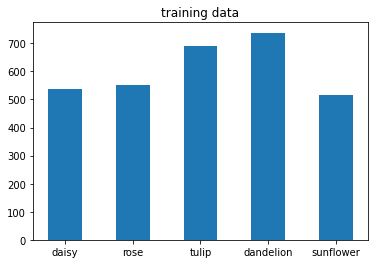

In [45]:
plt.bar(flower_types, [flower_dict[flower]['train'] for flower in flower_types], width=.5)
plt.title('training data')

the data set seems to be balanced

## investigate image sizes

In [46]:
def get_dims(img_path):
    img = Image.open(img_path)
    if img.mode != 'RGB':
        img = img.convert('RGB')
    arr = np.array(img, dtype='float32')
    h, w, d = arr.shape
    return h, w

In [47]:
size_dict = {}
for flower_type in flower_types:
    size_dict[flower_type] = []
    for folder in ['test', 'train', 'validation']:
        flower_path = os.path.join(path, folder, flower_type)
        if os.path.isdir(flower_path):
            images = os.listdir(flower_path)
            for image in images:
                h, w = get_dims(f'{flower_path}/{image}')
                size_dict[flower_type].append({'hight': h, 'width': w})

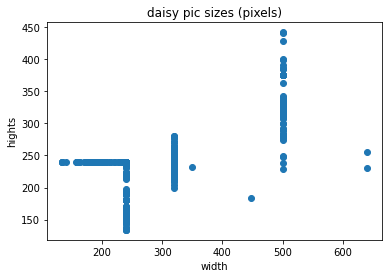

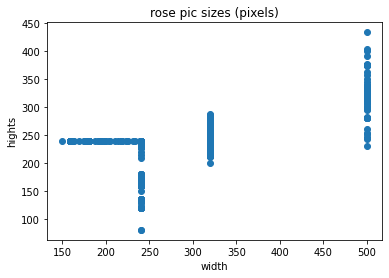

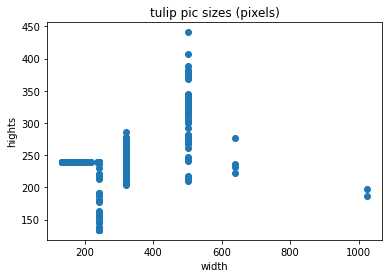

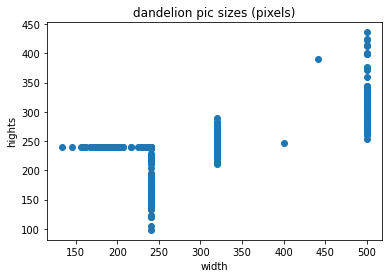

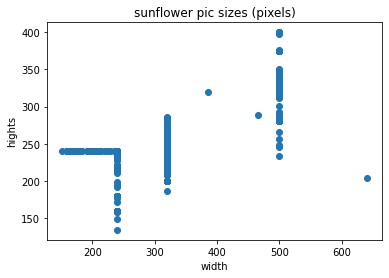

In [48]:
for flower in flower_types:
    hights = [pic['hight'] for pic in size_dict[flower]]
    widths = [pic['width'] for pic in size_dict[flower]]
    plt.scatter(widths, hights)
    plt.xlabel('width')
    plt.ylabel('hights')
    plt.title(f'{flower} pic sizes (pixels)')
    plt.pause(0.1)

size distribution between the different flower types seems similar

## show random images

../data/flowers/test/daisy


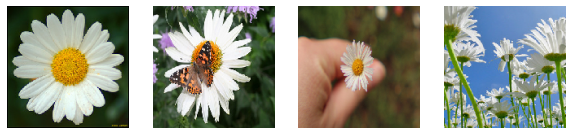

../data/flowers/train/daisy


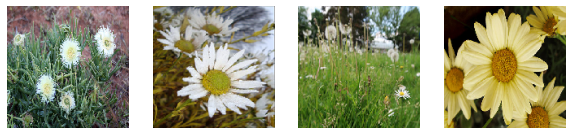

../data/flowers/validation/daisy


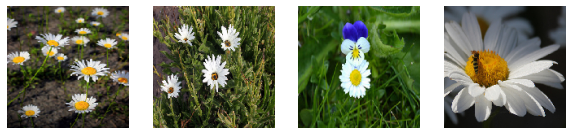

../data/flowers/test/rose


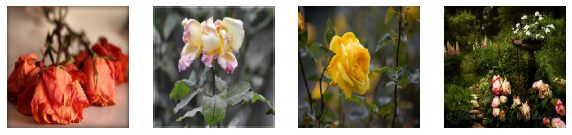

../data/flowers/train/rose


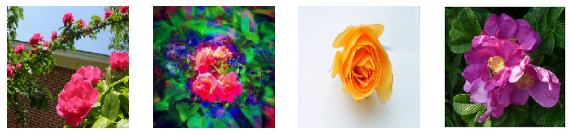

../data/flowers/validation/rose


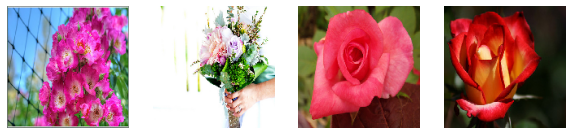

../data/flowers/test/tulip


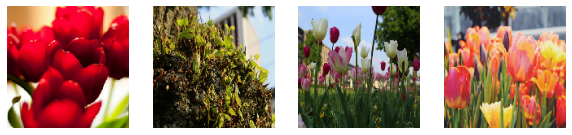

../data/flowers/train/tulip


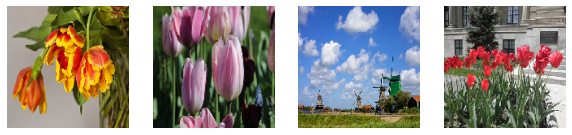

../data/flowers/validation/tulip


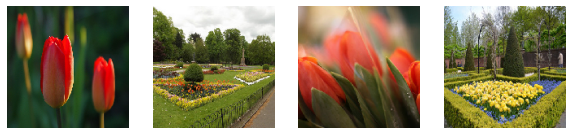

../data/flowers/test/dandelion


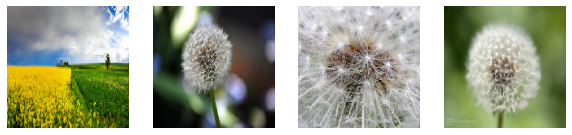

../data/flowers/train/dandelion


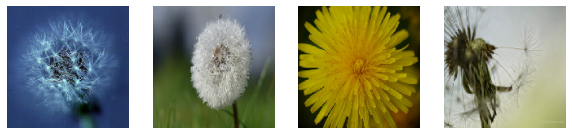

../data/flowers/validation/dandelion


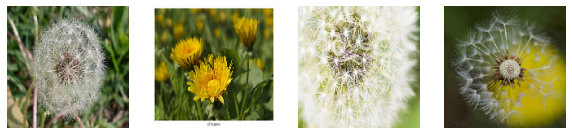

../data/flowers/test/sunflower


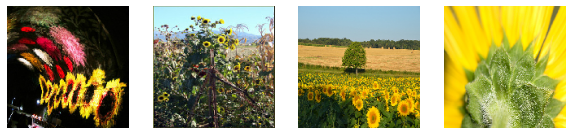

../data/flowers/train/sunflower


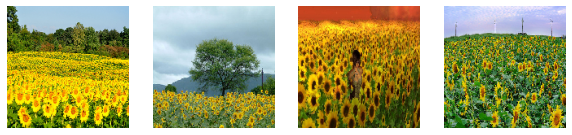

../data/flowers/validation/sunflower


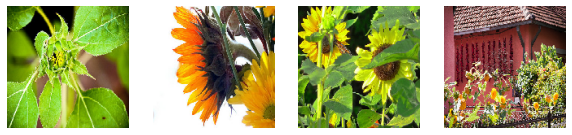

In [49]:
for flower_type in flower_types:
    for folder in ['test', 'train', 'validation']:
        flower_path = os.path.join(path, folder, flower_type)
        if os.path.isdir(flower_path):
            print(flower_path)
            images = os.listdir(flower_path)
            random.seed(1)
            random.shuffle(images)
            f, axarr = plt.subplots(1, 4, figsize=(10, 20))
            for i, img in enumerate(images[:4]):
                axarr[i].imshow(load_img(f'{flower_path}/{img}', target_size=target_size))
                axarr[i].axis('off')
            plt.pause(0.1)

almost all images look good

# start with easy model

In [50]:
def make_model():
    inputs = keras.Input(shape=(target_size[0], target_size[1], 3))
    conv = keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(inputs)
    pooling = keras.layers.MaxPool2D(strides=(2, 2))(conv)
    flatten = keras.layers.Flatten()(pooling)
    dense = keras.layers.Dense(64, activation='relu')(flatten)
    outputs = keras.layers.Dense(len(flower_types), activation='softmax')(dense)
    model = keras.Model(inputs, outputs)
    

    optimizer = keras.optimizers.SGD(lr=0.002, momentum=0.8)
    loss = keras.losses.CategoricalCrossentropy(from_logits=False)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    return model

In [51]:
initial_model = make_model()

/Users/a844494/.pyenv/versions/zoomcamp/lib/python3.9/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [52]:
train_generator = ImageDataGenerator(rescale=1./255)

train_data = train_generator.flow_from_directory(
    f'{path}train/',
    target_size=target_size,
    batch_size=20
)

Found 3029 images belonging to 5 classes.


In [53]:
val_generator = ImageDataGenerator(rescale=1./255)

val_data = val_generator.flow_from_directory(
    f'{path}validation',
    target_size=target_size,
    batch_size=20,
    shuffle=True
)

Found 644 images belonging to 5 classes.


In [54]:
train_data.class_mode

'categorical'

In [55]:
flower_types_pred_dict = {v:k for k, v in train_data.class_indices.items()}

In [56]:
history = initial_model.fit(
    train_data,
    steps_per_epoch=100,
    epochs=10,
    validation_data=val_data,
    validation_steps=10
)

Epoch 1/10
100/100 [==============================] - 11s 111ms/step - loss: 1.4654 - accuracy: 0.3499 - val_loss: 1.2603 - val_accuracy: 0.4650
Epoch 2/10
100/100 [==============================] - 12s 120ms/step - loss: 1.2619 - accuracy: 0.4540 - val_loss: 1.1930 - val_accuracy: 0.4700
Epoch 3/10
100/100 [==============================] - 12s 121ms/step - loss: 1.2066 - accuracy: 0.4816 - val_loss: 1.1683 - val_accuracy: 0.5050
Epoch 4/10
100/100 [==============================] - 12s 124ms/step - loss: 1.1286 - accuracy: 0.5215 - val_loss: 1.1576 - val_accuracy: 0.5100
Epoch 5/10
100/100 [==============================] - 13s 133ms/step - loss: 1.0643 - accuracy: 0.5616 - val_loss: 1.1374 - val_accuracy: 0.5750
Epoch 6/10
100/100 [==============================] - 12s 123ms/step - loss: 1.0708 - accuracy: 0.5600 - val_loss: 1.0604 - val_accuracy: 0.5950
Epoch 7/10
100/100 [==============================] - 12s 115ms/step - loss: 0.9729 - accuracy: 0.6229 - val_loss: 0.9941 - val_ac

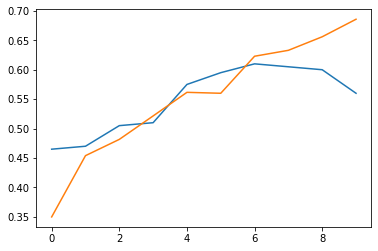

In [57]:
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['accuracy'])

# parameter tuning

In [58]:
def build_model(conv_layers=1, learning_rate=3e-3, dropout_rate=0.2):
    inputs = keras.Input(shape=(target_size[0], target_size[1], 3))
    
    conv = keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(inputs)
    pooling = keras.layers.MaxPool2D(strides=(2, 2))(conv)
    
    for layer in range(conv_layers):
        conv = keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(pooling)
        pooling = keras.layers.MaxPool2D(strides=(2, 2))(conv)
    
    
    flatten = keras.layers.Flatten()(pooling)
    dropout = keras.layers.Dropout(rate=dropout_rate)(flatten)
    dense = keras.layers.Dense(64, activation='relu')(dropout)
    outputs = keras.layers.Dense(len(flower_types), activation='softmax')(dense)
    
    
    model = keras.Model(inputs, outputs)
    

    optimizer = keras.optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999)
    loss = keras.losses.CategoricalCrossentropy(from_logits=False)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    return model

In [59]:
chechpoint = keras.callbacks.ModelCheckpoint(
'flower_model_{epoch:02d}_{val_accuracy:.3f}.h5',
save_best_only=True,
monitor='val_accuracy',
mode='max')

In [60]:
model = build_model()

In [61]:
history = model.fit(
    train_data,
    steps_per_epoch=100,
    epochs=10,
    validation_data=val_data,
    validation_steps=10,
    callbacks=[chechpoint]
)

Epoch 1/10
100/100 [==============================] - 15s 146ms/step - loss: 1.6843 - accuracy: 0.3860 - val_loss: 1.2688 - val_accuracy: 0.4700
Epoch 2/10
100/100 [==============================] - 16s 162ms/step - loss: 1.2175 - accuracy: 0.5040 - val_loss: 1.1829 - val_accuracy: 0.5050
Epoch 3/10
100/100 [==============================] - 16s 156ms/step - loss: 1.0920 - accuracy: 0.5752 - val_loss: 1.0500 - val_accuracy: 0.5950
Epoch 4/10
100/100 [==============================] - 16s 159ms/step - loss: 0.9932 - accuracy: 0.6129 - val_loss: 1.1382 - val_accuracy: 0.5600
Epoch 5/10
100/100 [==============================] - 15s 154ms/step - loss: 0.8667 - accuracy: 0.6601 - val_loss: 1.0295 - val_accuracy: 0.6200
Epoch 6/10
100/100 [==============================] - 15s 151ms/step - loss: 0.6964 - accuracy: 0.7380 - val_loss: 1.2625 - val_accuracy: 0.5600
Epoch 7/10
100/100 [==============================] - 17s 166ms/step - loss: 0.5611 - accuracy: 0.7960 - val_loss: 1.2039 - val_ac

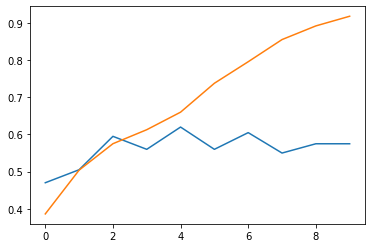

In [62]:
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['accuracy'])

In [63]:
scores = {}
for lr in [0.0001, 0.001, 0.01]:
    print(lr)
    m = build_model(learning_rate=lr)
    history = m.fit(
    train_data,
    steps_per_epoch=80,
    epochs=8,
    validation_data=val_data,
    validation_steps=10,
    callbacks=[chechpoint])
    scores[lr] = history.history
    print()

0.0001
Epoch 1/8
80/80 [==============================] - 14s 167ms/step - loss: 1.4485 - accuracy: 0.3769 - val_loss: 1.2854 - val_accuracy: 0.4650
Epoch 2/8
80/80 [==============================] - 12s 154ms/step - loss: 1.2170 - accuracy: 0.4909 - val_loss: 1.0853 - val_accuracy: 0.5250
Epoch 3/8
80/80 [==============================] - 12s 155ms/step - loss: 1.1477 - accuracy: 0.5288 - val_loss: 1.1915 - val_accuracy: 0.5150
Epoch 4/8
80/80 [==============================] - 12s 148ms/step - loss: 1.0829 - accuracy: 0.5570 - val_loss: 1.0860 - val_accuracy: 0.5450
Epoch 5/8
80/80 [==============================] - 12s 149ms/step - loss: 1.0476 - accuracy: 0.5619 - val_loss: 1.0560 - val_accuracy: 0.5350
Epoch 6/8
80/80 [==============================] - 12s 149ms/step - loss: 0.9790 - accuracy: 0.6180 - val_loss: 1.0341 - val_accuracy: 0.5800
Epoch 7/8
80/80 [==============================] - 12s 149ms/step - loss: 0.9478 - accuracy: 0.6369 - val_loss: 1.1650 - val_accuracy: 0.5200

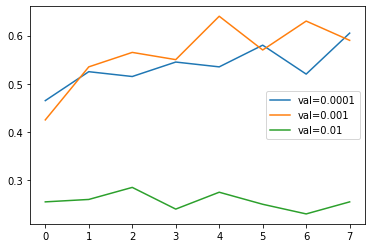

In [64]:
for lr, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % lr))

plt.legend()

In [65]:
scores = {}
for dr in [0.1, 0.2]:
    print(dr)
    m = build_model(dropout_rate=dr)
    history = m.fit(
    train_data,
    steps_per_epoch=80,
    epochs=8,
    validation_data=val_data,
    validation_steps=10,
    callbacks=[chechpoint])
    scores[dr] = history.history
    print()

0.1
Epoch 1/8
80/80 [==============================] - 13s 154ms/step - loss: 1.8370 - accuracy: 0.2467 - val_loss: 1.6007 - val_accuracy: 0.2500
Epoch 2/8
80/80 [==============================] - 14s 178ms/step - loss: 1.6003 - accuracy: 0.2511 - val_loss: 1.5920 - val_accuracy: 0.2750
Epoch 3/8
80/80 [==============================] - 15s 190ms/step - loss: 1.5990 - accuracy: 0.2423 - val_loss: 1.6118 - val_accuracy: 0.2250
Epoch 4/8
80/80 [==============================] - 16s 199ms/step - loss: 1.6008 - accuracy: 0.2400 - val_loss: 1.6062 - val_accuracy: 0.2250
Epoch 5/8
80/80 [==============================] - 14s 180ms/step - loss: 1.6052 - accuracy: 0.2310 - val_loss: 1.6037 - val_accuracy: 0.2500
Epoch 6/8
80/80 [==============================] - 18s 228ms/step - loss: 1.5984 - accuracy: 0.2505 - val_loss: 1.5922 - val_accuracy: 0.2500
Epoch 7/8
80/80 [==============================] - 14s 179ms/step - loss: 1.5990 - accuracy: 0.2486 - val_loss: 1.5828 - val_accuracy: 0.2650
Ep

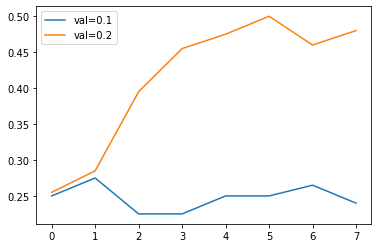

In [66]:
for dr, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % dr))

plt.legend()

In [67]:
scores = {}
for layer in [1, 2]:
    print(layer)
    m = build_model(conv_layers=layer)
    history = m.fit(
    train_data,
    steps_per_epoch=80,
    epochs=8,
    validation_data=val_data,
    validation_steps=10,
    callbacks=[chechpoint])
    scores[layer] = history.history
    print()

1
Epoch 1/8
80/80 [==============================] - 13s 159ms/step - loss: 1.8166 - accuracy: 0.2354 - val_loss: 1.6032 - val_accuracy: 0.2550
Epoch 2/8
80/80 [==============================] - 13s 157ms/step - loss: 1.6037 - accuracy: 0.2406 - val_loss: 1.6146 - val_accuracy: 0.1950
Epoch 3/8
80/80 [==============================] - 13s 161ms/step - loss: 1.6010 - accuracy: 0.2473 - val_loss: 1.5989 - val_accuracy: 0.2400
Epoch 4/8
80/80 [==============================] - 14s 171ms/step - loss: 1.6003 - accuracy: 0.2442 - val_loss: 1.5966 - val_accuracy: 0.2450
Epoch 5/8
80/80 [==============================] - 13s 159ms/step - loss: 1.5955 - accuracy: 0.2498 - val_loss: 1.5931 - val_accuracy: 0.2900
Epoch 6/8
80/80 [==============================] - 13s 159ms/step - loss: 1.5972 - accuracy: 0.2438 - val_loss: 1.5991 - val_accuracy: 0.2600
Epoch 7/8
80/80 [==============================] - 12s 149ms/step - loss: 1.6020 - accuracy: 0.2385 - val_loss: 1.5900 - val_accuracy: 0.2950
Epoc

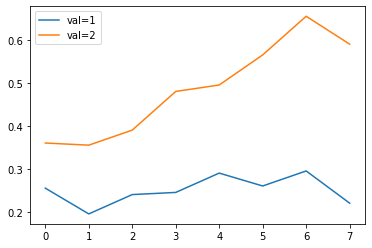

In [68]:
for layer, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % layer))

plt.legend()

# use test set to check the model

In [69]:
test_generator = ImageDataGenerator(rescale=1./255)

test_data = test_generator.flow_from_directory(
    f'{path}test',
    target_size=target_size,
    batch_size=20,
    class_mode='categorical',
    shuffle=False
)

Found 644 images belonging to 5 classes.


In [70]:
pred_test = model.predict_generator(test_data)
predicted_class_indices_test = np.argmax(pred_test,axis=1)
predictions = [flower_types_pred_dict[p] for p in predicted_class_indices_test]

/var/folders/rk/h56j88l56js33mhr0p2z2y5h0000gn/T/ipykernel_55603/2558488205.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred_test = model.predict_generator(test_data)


In [71]:
cm = confusion_matrix([flower_types_pred_dict[p] for p in predicted_class_indices_test], 
                 [flower_types_pred_dict[l] for l in test_data.labels], 
                 labels=list(flower_types_pred_dict.values()))

In [72]:
print(f'accuracy: {sum(predicted_class_indices_test == test_data.labels) / len(predicted_class_indices_test)}')

accuracy: 0.577639751552795


[Text(0, 0.5, 'daisy'),
 Text(0, 1.5, 'dandelion'),
 Text(0, 2.5, 'rose'),
 Text(0, 3.5, 'sunflower'),
 Text(0, 4.5, 'tulip')]

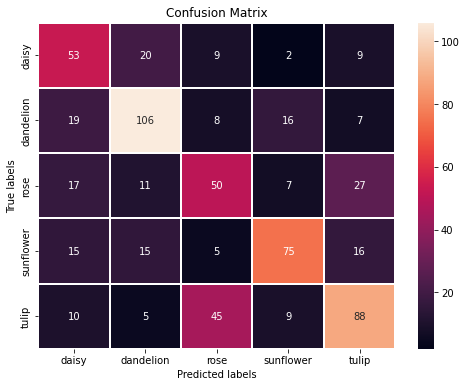

In [73]:
f, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', ax=ax, linewidths=0.1)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(list(flower_types_pred_dict.values()))
ax.yaxis.set_ticklabels(list(flower_types_pred_dict.values()))

# save model

In [74]:
model_path = '../models/flowers-model-v1.tflite'

In [75]:
converter = tflite.TFLiteConverter.from_keras_model(model)

tflite_model = converter.convert()

with open(model_path, 'wb') as f_out:
    f_out.write(tflite_model)

2021-12-14 17:17:14.196584: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /var/folders/rk/h56j88l56js33mhr0p2z2y5h0000gn/T/tmp9z_7aubx/assets


2021-12-14 17:17:15.603185: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:363] Ignored output_format.
2021-12-14 17:17:15.603207: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:366] Ignored drop_control_dependency.
2021-12-14 17:17:15.609052: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /var/folders/rk/h56j88l56js33mhr0p2z2y5h0000gn/T/tmp9z_7aubx
2021-12-14 17:17:15.614055: I tensorflow/cc/saved_model/reader.cc:107] Reading meta graph with tags { serve }
2021-12-14 17:17:15.614074: I tensorflow/cc/saved_model/reader.cc:148] Reading SavedModel debug info (if present) from: /var/folders/rk/h56j88l56js33mhr0p2z2y5h0000gn/T/tmp9z_7aubx
2021-12-14 17:17:15.626140: I tensorflow/cc/saved_model/loader.cc:210] Restoring SavedModel bundle.
2021-12-14 17:17:15.722115: I tensorflow/cc/saved_model/loader.cc:194] Running initialization op on SavedModel bundle at path: /var/folders/rk/h56j88l56js33mhr0p2z2y5h0000gn/T/tmp9z_7aubx
2021-12

# make a prediction

In [76]:
interpreter = tflite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]['index']
output_index = interpreter.get_output_details()[0]['index']

In [77]:
def prepare_image(img_path, target_size):
    with open(img_path, 'rb') as file:
        img = file.read()
        stream = BytesIO(img)
        img = Image.open(stream)
    
    if img.mode != 'RGB':
        img = img.convert('RGB')
    img = img.resize(target_size, Image.NEAREST)
    
    x = np.array(img, dtype='float32')
    X = np.array([x])
    X /= 255.0
    
    return X

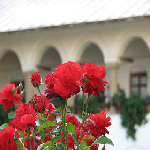

In [78]:
test_image = f'{path}test/rose/1461381091_aaaa663bbe_n.jpg'
load_img(test_image, target_size=target_size)

In [79]:
X = prepare_image(test_image, target_size)

In [80]:
interpreter.set_tensor(input_index, X)
interpreter.invoke()
preds = interpreter.get_tensor(output_index)

In [81]:
flower_types_pred_dict

{0: 'daisy', 1: 'dandelion', 2: 'rose', 3: 'sunflower', 4: 'tulip'}

In [82]:
flower_types_pred_dict[preds.argmax()]

'tulip'

# test local API

In [83]:
def download_image(url):
    with urllib.request.urlopen(url) as resp:
        buffer = resp.read()
    stream = BytesIO(buffer)
    img = Image.open(stream)
    return img

def resize_image(image, target_size):
    if image.mode != 'RGB':
        image = image.convert('RGB')
    image = image.resize(target_size, Image.NEAREST)
    return image

In [84]:
image_urls = [
    'https://upload.wikimedia.org/wikipedia/commons/c/cc/Hundsrose.jpg',
    'https://upload.wikimedia.org/wikipedia/commons/a/a8/Tulipa_cinnabarina_subsp_cinnabarina.png',
    'https://upload.wikimedia.org/wikipedia/commons/8/85/Tulipa_praestans1.jpg',
    'https://upload.wikimedia.org/wikipedia/commons/e/ea/Tulipa_suaveolens_floriade_to_Canberra.jpg',
    'https://upload.wikimedia.org/wikipedia/commons/e/eb/Wild_Rosa_gallica_Romania.jpg',
    'https://upload.wikimedia.org/wikipedia/commons/0/0c/Rosa_Ave_Maria_1.jpg',
    'https://upload.wikimedia.org/wikipedia/commons/f/f7/2010_sonnenblume_%28Helianthus_annuus%29.JPG',
    'https://upload.wikimedia.org/wikipedia/commons/e/e9/Sonsbeck_-_agri_06_ies.jpg',
    'https://upload.wikimedia.org/wikipedia/commons/d/d6/Taraxacum_officinale_focused.jpg',
    'https://upload.wikimedia.org/wikipedia/commons/8/85/01_pusteblume.jpg',
    'https://upload.wikimedia.org/wikipedia/commons/5/5a/Bellis_perennis-fully_bloomed_flower.jpg'    
]

In [ ]:
for url in image_urls:
    print(url)
    img = download_image(url)
    img = resize_image(img, target_size)
    display(img)

In [ ]:
# with docker
url = 'http://192.168.178.36:9696/predict'
image_url = 'https://upload.wikimedia.org/wikipedia/commons/a/a8/Tulipa_cinnabarina_subsp_cinnabarina.png'

print(image_url)
# img = download_image(image_url)
# img = resize_image(img, target_size)
# display(img)
flower_pic_url = {'url': image_url}
resp = requests.post(url, json=flower_pic_url).json()
print(resp)
print(f"It is a {resp['flower']}")
print()

# test Heroku APP

In [86]:
url = 'https://flower-types.herokuapp.com/predict'
flower_pic_url = {'url': 'https://upload.wikimedia.org/wikipedia/commons/c/cc/Hundsrose.jpg'}

requests.post(url, json=flower_pic_url).json()

{'daisy_prob': 0.5996599197387695,
 'dandelion_prob': 0.022527068853378296,
 'flower': 'daisy',
 'rose_prob': 0.2810279428958893,
 'sunflower_prob': 0.002170732943341136,
 'tulip_prob': 0.09461430460214615}

In [88]:
for image_url in image_urls:
    print(image_url)
    # img = download_image(image_url)
    # img = resize_image(img, target_size)
    # display(img)
    flower_pic_url = {'url': image_url}
    resp = requests.post(url, json=flower_pic_url).json()
    print(resp)
    print(f"It is a {resp['flower']}")
    print()

https://upload.wikimedia.org/wikipedia/commons/c/cc/Hundsrose.jpg
{'daisy_prob': 0.5996599197387695, 'dandelion_prob': 0.022527068853378296, 'flower': 'daisy', 'rose_prob': 0.2810279428958893, 'sunflower_prob': 0.002170732943341136, 'tulip_prob': 0.09461430460214615}
It is a daisy

https://upload.wikimedia.org/wikipedia/commons/a/a8/Tulipa_cinnabarina_subsp_cinnabarina.png
{'daisy_prob': 0.10178590565919876, 'dandelion_prob': 0.010768452659249306, 'flower': 'rose', 'rose_prob': 0.5585390329360962, 'sunflower_prob': 0.08482524752616882, 'tulip_prob': 0.24408146739006042}
It is a rose

https://upload.wikimedia.org/wikipedia/commons/8/85/Tulipa_praestans1.jpg
{'daisy_prob': 0.06188111752271652, 'dandelion_prob': 0.034026701003313065, 'flower': 'tulip', 'rose_prob': 0.037763215601444244, 'sunflower_prob': 0.19327868521213531, 'tulip_prob': 0.6730502843856812}
It is a tulip

https://upload.wikimedia.org/wikipedia/commons/e/ea/Tulipa_suaveolens_floriade_to_Canberra.jpg
{'daisy_prob': 0.00331